<a href="https://colab.research.google.com/github/pbrandl/nn_drsynth/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

*   **[Torch](https://pytorch.org/docs/)** is a neural network library.
*   **[IPython](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html)** is used for displaying and playing audio samples in this notebook.
*   **google.colab** is used to get access to Google Drive for importing the dataset file.
*   **pickle** is used to convert the dataset file to its original object.

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import pickle
from google.colab import drive
from IPython.display import Audio
from IPython.core.display import display
import matplotlib.pyplot as plt


# For Type Annotations
from typing import Generator, Mapping, Tuple, NamedTuple, Sequence, Callable


In [3]:
# @title Set Working Directories
# Mount Google Drive
drive.mount('/content/drive') 
project_path = '/content/drive/My Drive/nn_drum' # @param
dataset_path = '/content/drive/My Drive/nn_drum/snares214.tensor' # @param

# Select the Processing Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Working on {}.".format(device))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working on cuda.


In [4]:
# @title Load the Dataset
# @markdown The dataset is loaded as a numpy array, then shaped accoriding to the size of the batch
batch_size =  5 # @param
# @markdown The sample rate of the samples in the database
sample_rate = 44100 # @param

def load_dataset(path, device, to_numpy=False):
    with open(path, 'rb') as file:
        tensor = pickle.load(file)
        return tensor.numpy() if to_numpy else tensor.to(device)

dataset = load_dataset(dataset_path, device, to_numpy=False)
n_data = dataset.shape[0]
dataset = dataset.reshape(n_data // batch_size, batch_size, -1)
n_batches = dataset.shape[0]
print(f"Dataset shape {dataset.shape} with (num_batches, batch_size, sample_length).")

Dataset shape torch.Size([86, 5, 16384]) with (num_batches, batch_size, sample_length).


In [5]:
#@markdown Listen to a sample
Audio(dataset[0, 0, :], rate=sample_rate)

TypeError: ignored

# Variational Auto Encoder

In [13]:
#@title VAE classes and Train Funcitions
#@markdown VAEs sample from a Gaussian distribution. To optimize this distribution the ELBO $\mathcal{L}$ is maximized:  

#@markdown $$ \mathcal{L}(x) = \mathbb{E}_{z \sim q_\phi(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big).$$

#@markdown * $q_\phi(z|x)$ is the Gaussian posterior; the inferred latent distribution corresponding to the input $x$,
#@markdown * $p_\theta(x|z)$ is the likelihood of $x$ for latent $z$ according to our model,
#@markdown * $p(z)$ is our chosen prior, $\mathcal{N}(0, I)$, the centered unit variance gaussian. \\

#@markdown The KL divergence can be derived analytically as follow:
#@markdown $$ \mathbb{KL}\big( \mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1) \big) = \frac12 \big(\sigma^2  - \log(\sigma^2) + \mu^2 - 1 \big).$$


class AdaptiveActivation(nn.Module):
    """
        Adaptive activation function according to Em Karniadakis 2020.
        Title: "On the convergence of physics informed neural networks for linear 
        second-order elliptic and parabolic type PDEs"
    """
    def __init__(self, activation_fun: Callable):
        super(AdaptiveActivation, self).__init__()
        self.n = torch.Tensor([10]).to(device)
        self.a = nn.Parameter(torch.rand(1))
        self.activation_fun = activation_fun()
    
    def forward(self, x):
        return self.activation_fun(self.n * self.a * x)


class Encoder(nn.Module):
    def __init__(self, latent: int):
        super().__init__()
        self.latent = latent
        self.enc_l1 = nn.Linear(in_features=2**14, out_features=2**12)
        self.adapt_tanh0 = AdaptiveActivation(nn.Tanh)
        self.enc_l2 = nn.Linear(in_features=2**12, out_features=latent*2)
        self.adapt_tanh1 = AdaptiveActivation(nn.Tanh)

    def forward(self, x: Tensor):
        x = self.adapt_tanh0(self.enc_l1(x))
        x = self.adapt_tanh1(self.enc_l2(x))
        mu, logvar = x[:, :self.latent], x[:, self.latent:]
        return mu, logvar
        

class Decoder(nn.Module):
    def __init__(self, latent):
        super().__init__()
        self.dec_l1 = nn.Linear(in_features=latent, out_features=2**12)
        self.adapt_tanh0 = AdaptiveActivation(nn.Tanh)
        self.dec_l2 = nn.Linear(in_features=2**12, out_features=2**14)
        self.adapt_tanh1 = AdaptiveActivation(nn.Tanh)

    def forward(self, x: Tensor):
        x = self.adapt_tanh0(self.dec_l1(x))
        x = self.adapt_tanh1(self.dec_l2(x))

        return x


class VAE(nn.Module):
    def __init__(self, latent):
        super().__init__()

        self.encoder = Encoder(latent)
        self.decoder = Decoder(latent)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decoder(z)
        return x_recon, mean, logvar

    def generate(self, key):
        rng, key = jax.random.split(key)
        sampled_z = jax.random.normal(key, self.latents)
        return self.decoder(sampled_z)

    def reparameterize(self, mu: Tensor, log_var: Tensor):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample


def vae_loss(x_recon: Tensor, x: Tensor, mu: Tensor, logvar: Tensor):
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (F.mse_loss(x_recon, x) + kl_div)



In [14]:
model = VAE(2**12).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-05)

epochs = 50
x_recon_tmp = 0
for epoch in range(epochs):
    for i, batch in enumerate(dataset):
        optimizer.zero_grad()
        x_recon, mu, logvar = model(batch)
        loss = vae_loss(x_recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        
        if i % (n_batches // 2) == 0:
            print(f"Epoch: {epoch:03d} | Batch: {i:>2d}/{n_batches:02d} | Loss: {loss.item():>8.4f}")

Epoch: 049 | Batch: 60/86 | Loss:  22.4244
Epoch: 049 | Batch: 70/86 | Loss:  10.7844
Epoch: 049 | Batch: 80/86 | Loss:  10.4685


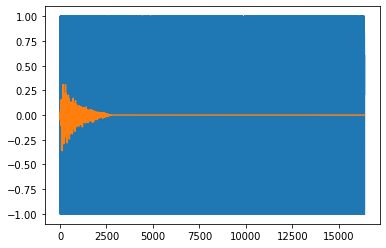

In [15]:
x_test = dataset[0, 0, :]
display(Audio(x_test.cpu().detach().numpy(), rate=sample_rate))

x_recon, _, _ = model(x_test.reshape(1, -1))
display(Audio(x_recon.cpu().detach().numpy(), rate=sample_rate))
plt.plot(x_recon.cpu().detach().numpy().squeeze())
plt.plot(x_test.cpu().detach().numpy())

In [ ]:
torch.save(model.state_dict(), project_path + 'snare214.model')